# SOLVERS

Importing the relevant libraries:

In [1]:
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt
import PIL

import time

from mip import *
import cplex
from cplex.exceptions import CplexError

Defining the generator:

In [2]:
# Class that will help create a connected graph

class UnionFind:
    def __init__(self, n):
        self.n = n  # number of trees in the forest
        self.v = [i for i in range(n)]  # initialize each disjoint set

    def find(self, u):
        while u != self.v[u]:
            self.v[u] = self.v[self.v[u]]  # compression technique
            u = self.v[u]
            
        return u
    
    def union(self, u, v):
        root_u, root_v = self.find(u), self.find(v)
        
        if root_u == root_v:
            return False  # union was not performed
        else:
            self.v[root_v] = root_u
            self.n -= 1

            return True  # union was not performed
        
# Defining the generator
        
class GraphGenerator:
    def __init__(self, N=100):
        self.N = N  # number os cells (default is a 10x10 grid)
        self.edges = self.generate_edges()
        
    def water_network(self):        
        # Copy the edges and create a disjoint set for each cell
        edges = self.edges.copy()
        forest = UnionFind(self.N)
        
        # Generate a graph
        G = nx.Graph()
        
        # Adding nodes
        # Initial value of flow is True because, initially, it is a connected graph
        for v in range(self.N):
            G.add_node(v, node_prop=None, flow=True, image=images["node_water"])
            
        step = 2*(self.N**0.5) + 2
            
        origin = np.random.randint(0, self.N)
        dest = np.random.choice([v for v in range(self.N) if v < origin-step or v > origin+step])
    
        G.nodes[origin]["node_prop"] = "origin"
        G.nodes[origin]["image"] = images["origin"]
        G.nodes[dest]["node_prop"] = "dest"
        G.nodes[dest]["image"] = images["dest"]
        
        # Adding edges
        # Makes sure that the initial graph will be connected
        # Edges with endpoint at origin or destination are marked as red
        # This color represents the constraint that prevents the deletion of an edge
        while forest.n > 1:
            v, w = edges.pop(np.random.randint(0, len(edges)))
            forest.union(v, w)
            G.add_edge(v, w, color="red" if G.nodes[v]["node_prop"] or G.nodes[w]["node_prop"] else "blue")
            
        return G
    
    def military_network(self):        
        # Copy the edges and create a disjoint set for each cell
        edges = self.edges.copy()
        forest = UnionFind(self.N)
        
        # Generate a graph
        G = nx.Graph()
        
        # Adding nodes
        endurances = np.random.choice(np.arange(1, 4), self.N, [0.2, 0.2, 0.6])
        for v, e in enumerate(endurances):
            G.add_node(v, node_prop=None, endurance=e, provided=True, image=images[f"base_{e}"])
            
        headquarters = np.random.randint(0, self.N)
    
        G.nodes[headquarters]["node_prop"] = "headquarters"
        G.nodes[headquarters]["endurance"] = 10000  # headquarters is the most difficult enemy military installation to attack
        G.nodes[headquarters]["image"] = images["headquarters"]
        
        # Adding edges
        # Makes sure that the initial graph will be connected
        while forest.n > 1:
            v, w = edges.pop(np.random.randint(0, len(edges)))
            forest.union(v, w)
            G.add_edge(v, w)
            
        # Harder to attack military installations adjacent to headquarters
        if v in G[headquarters]:
            G.nodes[v]["node_prop"] = "secure"
            G.nodes[v]["endurance"] = 100
                
        return G
                
    def available_edges(self, v):
        shape = int(self.N**0.5)  # takes into account the dimensions of the grid
        
        available_edges = []
        if (v+1) % shape != 0:
            available_edges.append((v, v+1))
        if v+shape < self.N:
            available_edges.append((v, v+shape))

        return available_edges  # possible edges in cell v

    def generate_edges(self):
        edges = []
        
        for v in range(self.N):
            edges.extend(self.available_edges(v))

        return edges

Defining function to display the water distribution network:

In [3]:
# Load images and defining constants

files = {"node_water" : "../media/node_water.png",
         "node" : "../media/node.png",
         "origin" : "../media/origin.png",
         "dest" : "../media/dest.png",
         "headquarters" : "../media/headquarters.png",
         "base_1" : "../media/base_1.png",
         "base_2" : "../media/base_2.png",
         "base_3" : "../media/base_3.png"}

images = {name : PIL.Image.open(file) for name, file in files.items()}

pos = {
    0: np.array([-0.51696583,  0.93714869]),
    1: np.array([-0.56742641,  0.82253354]),
    2: np.array([-0.62719935,  0.6729658 ]),
    3: np.array([-0.68765874,  0.50267799]),
    4: np.array([-0.74382698,  0.32035925]),
    5: np.array([-0.7941627 ,  0.13217055]),
    6: np.array([-0.83666331, -0.05578246]),
    7: np.array([-0.86996528, -0.23595114]),
    8: np.array([-0.89094869, -0.39926238]),
    9: np.array([-0.89163946, -0.53053518]),
    10: np.array([-0.38733367,  0.91693445]),
    11: np.array([-0.43712311,  0.80092016]),
    12: np.array([-0.49716983,  0.65037759]),
    13: np.array([-0.5581313 ,  0.48008344]),
    14: np.array([-0.61608378,  0.29792199]),
    15: np.array([-0.66749135,  0.10980975]),
    16: np.array([-0.71289509, -0.07778028]),
    17: np.array([-0.74890233, -0.25729352]),
    18: np.array([-0.77561893, -0.41942676]),
    19: np.array([-0.79111634, -0.54694834]),
    20: np.array([-0.21763917,  0.88636633]),
    21: np.array([-0.26705243,  0.77026095]),
    22: np.array([-0.32663326,  0.61904439]),
    23: np.array([-0.38874385,  0.44821624]),
    24: np.array([-0.44925398,  0.26544396]),
    25: np.array([-0.503791  ,  0.07726947]),
    26: np.array([-0.55185069, -0.1106987 ]),
    27: np.array([-0.59258626, -0.28972098]),
    28: np.array([-0.6253616 , -0.45151689]),
    29: np.array([-0.64908797, -0.57808267]),
    30: np.array([-0.0265184 ,  0.84316223]),
    31: np.array([-0.07569189,  0.72768255]),
    32: np.array([-0.13522642,  0.57630147]),
    33: np.array([-0.19846837,  0.4052692 ]),
    34: np.array([-0.26184534,  0.22231268]),
    35: np.array([-0.31914537,  0.03504394]),
    36: np.array([-0.37176953, -0.15155968]),
    37: np.array([-0.41760519, -0.33009058]),
    38: np.array([-0.45635494, -0.49089175]),
    39: np.array([-0.48610726, -0.61664203]),
    40: np.array([0.17306041, 0.7870388 ]),
    41: np.array([0.12523073, 0.67174665]),
    42: np.array([0.06542014, 0.52135366]),
    43: np.array([0.00057418, 0.35038808]),
    44: np.array([-0.06446017,  0.16881244]),
    45: np.array([-0.12665467, -0.01764184]),
    46: np.array([-0.18358474, -0.20284045]),
    47: np.array([-0.23517585, -0.37993201]),
    48: np.array([-0.28008131, -0.5395554 ]),
    49: np.array([-0.31520095, -0.66452575]),
    50: np.array([0.37367169, 0.71735255]),
    51: np.array([0.3261134 , 0.60349739]),
    52: np.array([0.26568384, 0.4533447 ]),
    53: np.array([0.20029084, 0.28232821]),
    54: np.array([0.13188387, 0.10076766]),
    55: np.array([ 0.06580071, -0.08512693]),
    56: np.array([ 0.00327433, -0.26912593]),
    57: np.array([-0.05435863, -0.44475043]),
    58: np.array([-0.10542573, -0.60277577]),
    59: np.array([-0.14543593, -0.72631346]),
    60: np.array([0.56559421, 0.6370167 ]),
    61: np.array([0.51816683, 0.52173925]),
    62: np.array([0.45742793, 0.37180072]),
    63: np.array([0.39078859, 0.20081206]),
    64: np.array([0.32068581, 0.01991257]),
    65: np.array([ 0.25061104, -0.16499424]),
    66: np.array([ 0.18319807, -0.34754591]),
    67: np.array([ 0.11983138, -0.52158416]),
    68: np.array([ 0.06301685, -0.6776568 ]),
    69: np.array([ 0.0186711 , -0.79902472]),
    70: np.array([0.73944725, 0.54937204]),
    71: np.array([0.69356718, 0.43354057]),
    72: np.array([0.63327831, 0.28299777]),
    73: np.array([0.56640157, 0.11362039]),
    74: np.array([ 0.49475948, -0.06586195]),
    75: np.array([ 0.42219951, -0.24879945]),
    76: np.array([ 0.3508318 , -0.42919368]),
    77: np.array([ 0.28323608, -0.60006218]),
    78: np.array([ 0.22174755, -0.75283945]),
    79: np.array([ 0.17375926, -0.87138453]),
    80: np.array([0.88851998, 0.46293385]),
    81: np.array([0.84461033, 0.34637144]),
    82: np.array([0.78622939, 0.19742634]),
    83: np.array([0.71890696, 0.03077887]),
    84: np.array([ 0.64701115, -0.14610216]),
    85: np.array([ 0.57298256, -0.32634267]),
    86: np.array([ 0.4991802 , -0.50380042]),
    87: np.array([ 0.42843525, -0.67146086]),
    88: np.array([ 0.36371804, -0.82063715]),
    89: np.array([ 0.31246931, -0.93602742]),
    90: np.array([1.        , 0.39207751]),
    91: np.array([0.95865002, 0.27626818]),
    92: np.array([0.90164736, 0.12886004]),
    93: np.array([ 0.83495187, -0.03602707]),
    94: np.array([ 0.76248999, -0.21032434]),
    95: np.array([ 0.68749931, -0.38815742]),
    96: np.array([ 0.61223136, -0.5631032 ]),
    97: np.array([ 0.53957587, -0.72800535]),
    98: np.array([ 0.47280378, -0.87360199]),
    99: np.array([ 0.41929671, -0.98512662])
}

def plot_water_network(network):
    fig, ax = plt.subplots(figsize=(24, 16))

    nx.draw_networkx_edges(network, pos=pos, ax=ax, width=6,
                           edge_color=nx.get_edge_attributes(network, "color").values())
    nx.draw_networkx_edge_labels(network, pos, {edge : str(edge) for edge in network.edges})

    tr_figure = ax.transData.transform
    tr_axes = fig.transFigure.inverted().transform

    icon_size = (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.005
    icon_center = icon_size / 2.0

    for n in network.nodes:
        xf, yf = tr_figure(pos[n])
        xa, ya = tr_axes((xf, yf))

        a = plt.axes([xa - icon_center, ya - icon_center, icon_size, icon_size])

        a.imshow(network.nodes[n]["image"])
        a.axis("off")

    plt.show()

## MIP Solver

Class to perform the otimization:

In [4]:
def mip_water_network(network):
    for node, prop in network.nodes.data("node_prop"):
        if prop == "origin":
            origin = node
        elif prop == "dest":
            dest = node
            
    # Create a model
    model = Model(sense=MINIMIZE, solver_name=CBC)
    
    # Defining the variables
    x = [model.add_var(var_type=BINARY, name=f"x_{i}")
         for i in network.nodes]
    y = {(i, j) : model.add_var(var_type=BINARY, name=f"y_{i}_{j}")
         for i, j in network.edges}
    
    # Defining the objective function
    model.objective = xsum(y_ij for y_ij in y.values())
        
    # Defining the constraints
    model += x[origin] == 0
    model += x[dest] == 1
    
    for v, w in network.edges:
        model += y[v, w] >= x[v] - x[w]
        model += y[v, w] >= x[w] - x[v]
        
        if network[v][w]["color"] == "red":
            model += y[v, w] == 0
    
    return model

Testing the MIP solver:

In [5]:
# Generating a graph representing a water distribution network

generator = GraphGenerator()

water_network = generator.water_network()

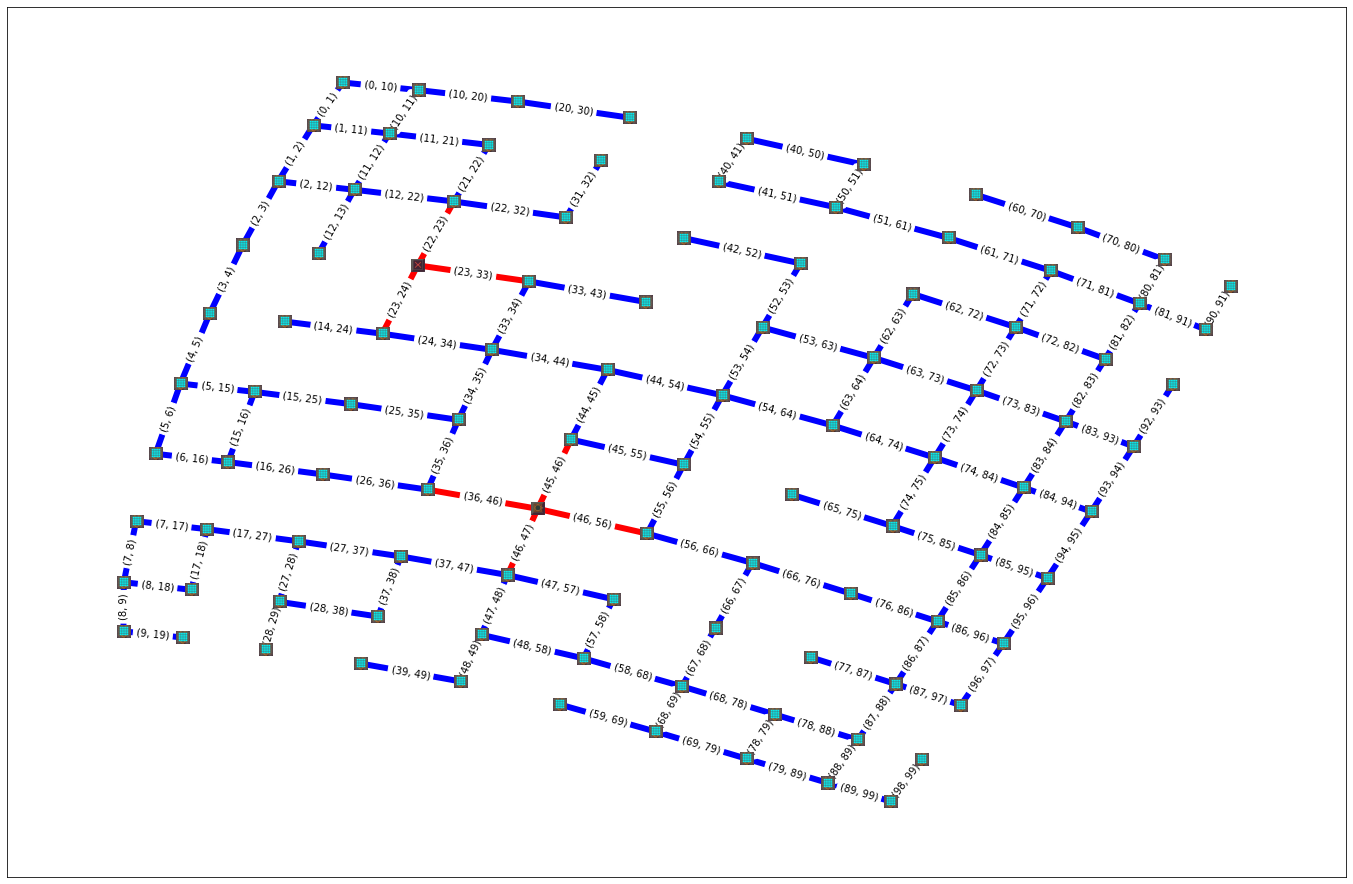

In [6]:
plot_water_network(water_network)

In [7]:
model = mip_water_network(water_network)
model.optimize()

Welcome to the CBC MILP Solver 
Version: devel 
Build Date: Nov 15 2020 

Starting solution of the Linear programming relaxation problem using Primal Simplex

Coin0506I Presolve 226 (-41) rows, 209 (-20) columns and 664 (-119) elements
Clp1000I sum of infeasibilities 3.37785e-05 - average 1.49462e-07, 77 fixed columns
Coin0506I Presolve 201 (-25) rows, 132 (-77) columns and 484 (-180) elements
Clp0029I End of values pass after 132 iterations
Clp0014I Perturbing problem by 0.001% of 1.0000007 - largest nonzero change 2.8691903e-05 ( 0.0014345952%) - largest zero change 2.9394864e-05
Clp0000I Optimal - objective value 3
Clp0000I Optimal - objective value 3
Coin0511I After Postsolve, objective 3, infeasibilities - dual 0 (0), primal 0 (0)
Clp0000I Optimal - objective value 3
Clp0000I Optimal - objective value 3
Clp0000I Optimal - objective value 3
Coin0511I After Postsolve, objective 3, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 3 - 0 iterations time 0.022, Pres

<OptimizationStatus.OPTIMAL: 0>

In [8]:
print(f"Optimization status is \"{model.status.name}\".")
      
print()
      
print("Getting the results:")
print(f"Optimal solution = {model.objective_value}")

print()

# Displaying variables that have been assigned a 1
for v in model.vars[100:]:
    if v.x:
        print(f"{v.name} = {v.x}")

Optimization status is "OPTIMAL".

Getting the results:
Optimal solution = 3.0

y_2_3 = 1.0
y_24_34 = 1.0
y_33_34 = 1.0


In [9]:
# Removing edges obtained by the model and updating the flow on nodes

for (v, w), var in zip(water_network.edges, model.vars[100:]):
    if var.x:
        water_network.remove_edge(v, w)

for v, var in zip(water_network.nodes, model.vars[:100]):
    if var.x:
        water_network.nodes[v]["flow"] = False
        water_network.nodes[v]["image"] = images["node"]

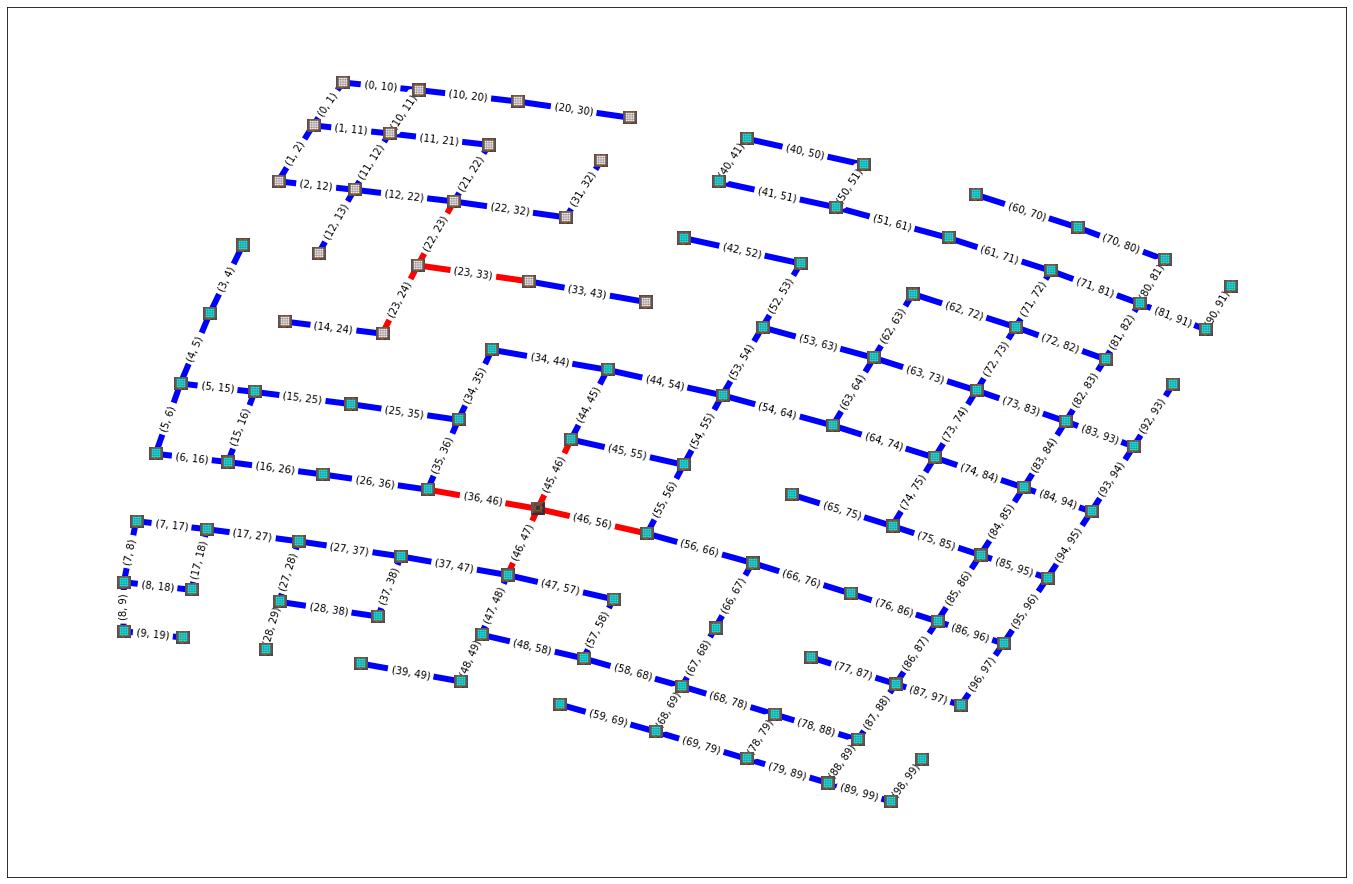

In [10]:
# Checking the result

plot_water_network(water_network)

## CPLEX Solver

In [11]:
def cplex_water_network(network):
    for node, prop in network.nodes.data("node_prop"):
        if prop == "origin":
            origin = node
        elif prop == "dest":
            dest = node

    # Create a model
    model = cplex.Cplex()
    model.objective.set_sense(model.objective.sense.minimize)

    model.parameters.lpmethod.set(model.parameters.lpmethod.values.network)

    # Create variables
    x = list(model.variables.add(obj=[0]*network.number_of_nodes(),
                                 ub=[1]*network.number_of_nodes(),
                                 types=["B"]*network.number_of_nodes()))
    y = dict(zip(network.edges, model.variables.add(obj=[1]*network.number_of_edges(),
                                                    ub=[1]*network.number_of_edges(),
                                                    types=["B"]*network.number_of_edges())))

    # Defining the constraints 
    model.linear_constraints.add(lin_expr=[[[x[origin]], [1]]],
                                 senses=["E"], rhs=[0])
    model.linear_constraints.add(lin_expr=[[[x[dest]], [1]]],
                                 senses=["E"], rhs=[1])

    for v, w in network.edges:
        model.linear_constraints.add(lin_expr=[[[y[v, w], x[v], x[w]], [-1, 1, -1]]],
                                     senses=["L"], rhs=[0.0])
        model.linear_constraints.add(lin_expr=[[[y[v, w], x[w], x[v]], [-1, 1, -1]]],
                                     senses=["L"], rhs=[0.0])

        if network[v][w]["color"] == "red":
            model.linear_constraints.add(lin_expr=[[[y[v, w]], [1]]],
                                         senses=["E"], rhs=[0.0])

    return model

Testing the CPLEX solver:

In [12]:
# Generating a graph representing a water distribution network

generator = GraphGenerator()

water_network = generator.water_network()

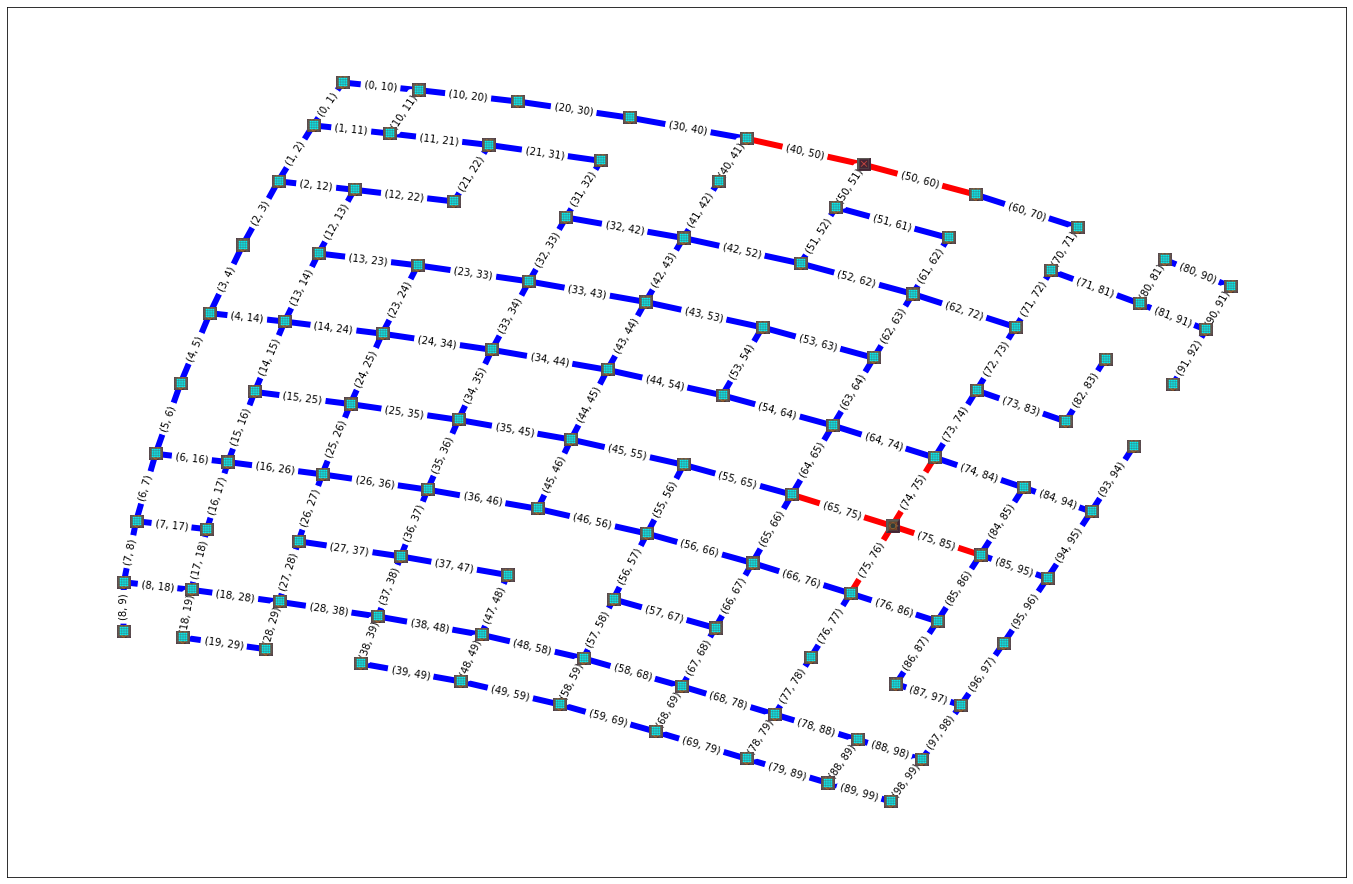

In [13]:
plot_water_network(water_network)

In [14]:
model = cplex_water_network(water_network)
model.solve()

Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Tried aggregator 5 times.
MIP Presolve eliminated 107 rows and 70 columns.
Aggregator did 24 substitutions.
Reduced MIP has 178 rows, 145 columns, and 534 nonzeros.
Reduced MIP has 145 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.28 ticks)
Found incumbent of value 5.000000 after 0.01 sec. (1.38 ticks)
Probing time = 0.00 sec. (0.03 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 178 rows, 145 columns, and 534 nonzeros.
Reduced MIP has 145 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.34 ticks)
Probing time = 0.00 sec. (0.03 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.34 ticks)

        Nodes             

In [15]:
print(f"Optimization status is \"{model.solution.status[model.solution.get_status()]}\".")
      
print()
      
print("Getting the results:")
print(f"Optimal solution = {model.solution.get_objective_value()}")

print()

# Displaying variables that have been assigned a 1
for (v, w), value in zip(water_network.edges, model.solution.get_values()[100:]):
    if value:
        print(f"y_{v}_{w} = {value}")

Optimization status is "MIP_optimal".

Getting the results:
Optimal solution = 5.0

y_20_30 = 1.0
y_41_42 = 1.0
y_51_52 = 1.0
y_61_62 = 1.0
y_71_72 = 1.0


In [16]:
# Removing edges obtained by the model and updating the flow on nodes

for (v, w), value in zip(water_network.edges, model.solution.get_values()[100:]):
    if value:
        water_network.remove_edge(v, w)
        
for v, value in zip(water_network.nodes, model.solution.get_values()[:100]):
    if value:
        water_network.nodes[v]["flow"] = False
        water_network.nodes[v]["image"] = images["node"]

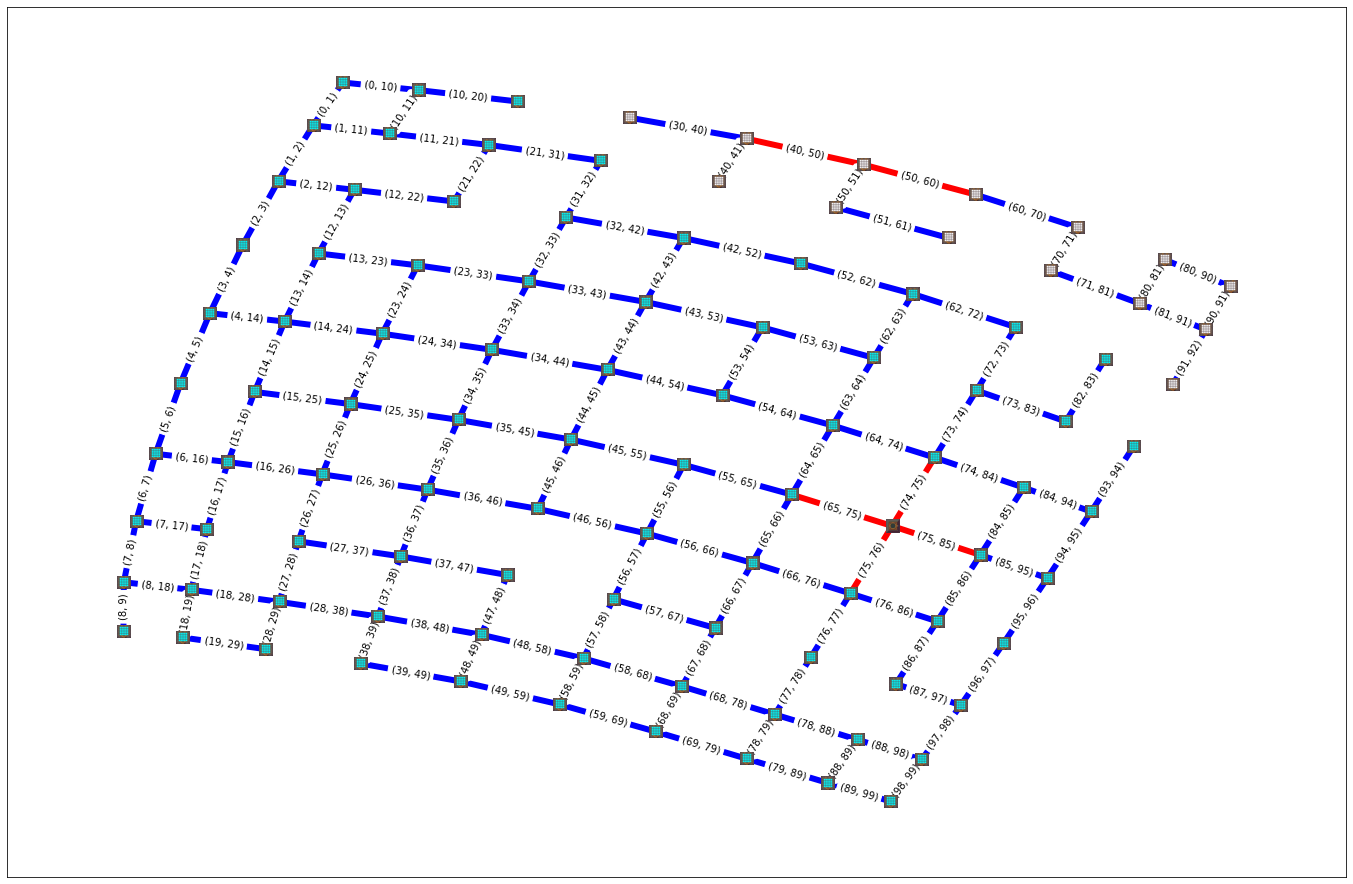

In [17]:
# Checking the results

plot_water_network(water_network)

## Comparing the Solvers

Performing several iterations of the two solvers:

In [18]:
generator = GraphGenerator()

N = 100

time_mip = np.zeros(N)
time_cplex = np.zeros(N)

objective_mip = np.zeros(N)
objective_cplex = np.zeros(N)

for i in range(N):
    water_network = generator.water_network()
    
    start_mip = time.time()
    model_mip = mip_water_network(water_network)
    model_mip.optimize()
    end_mip = time.time()
    
    start_cplex = time.time()
    model_cplex = cplex_water_network(water_network)
    model_cplex.solve()
    end_cplex = time.time()
    
    time_mip[i] = end_mip - start_mip
    time_cplex[i] = end_cplex - start_cplex
    
    objective_mip[i] = model_mip.objective_value
    objective_cplex[i] = model_cplex.solution.get_objective_value()

Cgl0002I 8 variables fixed
Cgl0004I processed model has 226 rows, 209 columns (209 integer (209 of which binary)) and 664 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 0.255%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 3
Cbc0038I Before mini branch and bound, 209 integers at bound fixed and 0 continuous
Cbc0038I Mini branch and bound did not improve solution (0.02 seconds)
Cbc0038I After 0.02 seconds - Feasibility pump exiting with objective of 3 - took 0.00 seconds
Cbc0012I Integer solution of 3 found by feasibility pump after 0 iterations and 0 nodes (0.02 seconds)
Cbc0001I Search completed - best objective 3, took 0 iterations and 0 nodes (0.02 seconds)
Cbc0035I Maximum depth 0, 0 variables fixed on reduced cost
Total time (CPU seconds):       0.03   (Wallclock seconds):       0.03

Starting solution of the Linear programming relaxation problem using Primal 

Coin0506I Presolve 275 (-35) rows, 234 (-17) columns and 814 (-100) elements
Clp1000I sum of infeasibilities 3.79676e-05 - average 1.38064e-07, 38 fixed columns
Coin0506I Presolve 275 (0) rows, 196 (-38) columns and 738 (-76) elements
Clp0006I 0  Obj 2.0047638 Dual inf 1.049895 (105)
Clp0029I End of values pass after 196 iterations
Clp0029I End of values pass after 316 iterations
Clp0029I End of values pass after 348 iterations
Clp0014I Perturbing problem by 0.001% of 1.0000005 - largest nonzero change 2.2273756e-05 ( 0.0011136878%) - largest zero change 2.9576128e-05
Clp0000I Optimal - objective value 2
Clp0000I Optimal - objective value 2
Coin0511I After Postsolve, objective 2, infeasibilities - dual 0 (0), primal 0 (0)
Clp0006I 0  Obj 2
Clp0000I Optimal - objective value 2
Clp0000I Optimal - objective value 2
Clp0000I Optimal - objective value 2
Coin0511I After Postsolve, objective 2, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 2 - 0 iterations time 0.042, 

Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Tried aggregator 3 times.
MIP Presolve eliminated 136 rows and 87 columns.
Aggregator did 22 substitutions.
Reduced MIP has 134 rows, 112 columns, and 402 nonzeros.
Reduced MIP has 112 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.19 ticks)
Found incumbent of value 9.000000 after 0.02 sec. (1.28 ticks)
Probing time = 0.00 sec. (0.03 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 134 rows, 112 columns, and 402 nonzeros.
Reduced MIP has 112 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.26 ticks)
Probing time = 0.00 sec. (0.03 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.29 ticks)

        Nodes             

Presolve time = 0.01 sec. (0.51 ticks)
Probing time = 0.00 sec. (0.04 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.36 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                            8.0000        0.0000           100.00%
*     0+    0                            7.0000        0.0000           100.00%
*     0     0      integral     0        5.0000        5.0000       78    0.00%
Elapsed time = 0.06 sec. (2.60 ticks, tree = 0.00 MB, solutions = 3)

Root node processing (before b&c):
  Real time             =    0.06 sec. (2.61 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          -----------

Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.07 sec. (1.77 ticks)
Cgl0002I 7 variables fixed
Cgl0004I processed model has 229 rows, 211 columns (211 integer (211 of which binary)) and 676 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 0.249%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 3
Cbc0038I Before mini branch and bound, 211 integers at bound fixed and 0 continuous
Cbc0038I Mini branch and bound did not improve solution (0.02 seconds)
Cbc0038I After 0.02 seconds - Feasibility pump exiting with objective of 3 - took 0.00 seconds
Cbc0012I Integer solution of 3 found by feasibility pump after 0 iterations and 0 nodes (0.02 seconds)
Cbc0001I Search completed - best objective 3, took 0 

                          ------------
Total (root+branch&cut) =    0.07 sec. (2.73 ticks)
Cgl0002I 8 variables fixed
Cgl0004I processed model has 294 rows, 246 columns (246 integer (246 of which binary)) and 866 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 0.216%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 4
Cbc0038I Before mini branch and bound, 246 integers at bound fixed and 0 continuous
Cbc0038I Mini branch and bound did not improve solution (0.03 seconds)
Cbc0038I After 0.03 seconds - Feasibility pump exiting with objective of 4 - took 0.00 seconds
Cbc0012I Integer solution of 4 found by feasibility pump after 0 iterations and 0 nodes (0.03 seconds)
Cbc0001I Search completed - best objective 4, took 0 iterations and 0 nodes (0.03 seconds)
Cbc0035I Maximum depth 0, 0 variables fixed on reduced cost
Total time (CPU seconds):       0.04   (Wallclock seconds

Coin0506I Presolve 292 (-31) rows, 243 (-15) columns and 866 (-89) elements
Clp1000I sum of infeasibilities 5.04289e-05 - average 1.72702e-07, 20 fixed columns
Coin0506I Presolve 292 (0) rows, 223 (-20) columns and 826 (-40) elements
Clp0006I 0  Obj 5.0033279 Dual inf 1.309869 (131)
Clp0029I End of values pass after 223 iterations
Clp0029I End of values pass after 343 iterations
Clp0029I End of values pass after 384 iterations
Clp0014I Perturbing problem by 0.001% of 1.0000004 - largest nonzero change 2.623149e-05 ( 0.0013115745%) - largest zero change 2.9669812e-05
Clp0000I Optimal - objective value 5
Clp0000I Optimal - objective value 5
Coin0511I After Postsolve, objective 5, infeasibilities - dual 0 (0), primal 0 (0)
Clp0006I 0  Obj 5 Dual inf 0.999999 (1)
Clp0014I Perturbing problem by 0.001% of 1.0000004 - largest nonzero change 2.623149e-05 ( 0.0013115745%) - largest zero change 2.9669812e-05
Clp0000I Optimal - objective value 5
Clp0000I Optimal - objective value 5
Clp0000I Optim

Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Tried aggregator 3 times.
MIP Presolve eliminated 125 rows and 90 columns.
MIP Presolve modified 3 coefficients.
Aggregator did 12 substitutions.
Reduced MIP has 146 rows, 121 columns, and 438 nonzeros.
Reduced MIP has 121 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (1.19 ticks)
Found incumbent of value 4.000000 after 0.02 sec. (1.29 ticks)
Probing time = 0.00 sec. (0.03 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 146 rows, 121 columns, and 438 nonzeros.
Reduced MIP has 121 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.28 ticks)
Probing time = 0.00 sec. (0.03 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0

   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                            8.0000        0.0000           100.00%
*     0+    0                            2.0000        0.0000           100.00%
      0     0        cutoff              2.0000        2.0000       69    0.00%
      0     0        cutoff              2.0000        2.0000       69    0.00%
Elapsed time = 0.07 sec. (2.08 ticks, tree = 0.01 MB, solutions = 2)

Root node processing (before b&c):
  Real time             =    0.08 sec. (2.09 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.08 sec. (2.09 ticks)
Cgl0002I 8 variables fixed
Cgl0004I processed model has 260 rows, 226 columns (226 integer (226 of which binary)) and 768 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 0.232%
C

Coin0506I Presolve 268 (-43) rows, 232 (-19) columns and 788 (-127) elements
Clp1000I sum of infeasibilities 6.36004e-05 - average 2.37315e-07, 31 fixed columns
Coin0506I Presolve 268 (0) rows, 201 (-31) columns and 726 (-62) elements
Clp0006I 0  Obj 5.0051031 Primal inf 3.4359421e-06 (13) Dual inf 1.4e+09 (121)
Clp0029I End of values pass after 201 iterations
Clp0014I Perturbing problem by 0.001% of 1.0000005 - largest nonzero change 2.8682824e-05 ( 0.0014341412%) - largest zero change 2.9576128e-05
Clp0000I Optimal - objective value 5
Clp0000I Optimal - objective value 5
Coin0511I After Postsolve, objective 5, infeasibilities - dual 0 (0), primal 0 (0)
Clp0006I 0  Obj 5
Clp0000I Optimal - objective value 5
Clp0000I Optimal - objective value 5
Clp0000I Optimal - objective value 5
Coin0511I After Postsolve, objective 5, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 5 - 0 iterations time 0.042, Presolve 0.00, Idiot 0.04

Starting MIP optimization
Version identifi

Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Tried aggregator 4 times.
MIP Presolve eliminated 141 rows and 96 columns.
MIP Presolve modified 3 coefficients.
Aggregator did 16 substitutions.
Reduced MIP has 132 rows, 107 columns, and 396 nonzeros.
Reduced MIP has 107 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (1.27 ticks)
Found incumbent of value 6.000000 after 0.02 sec. (1.35 ticks)
Probing time = 0.00 sec. (0.03 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 132 rows, 107 columns, and 396 nonzeros.
Reduced MIP has 107 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.25 ticks)
Probing time = 0.00 sec. (0.03 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0

Probing time = 0.00 sec. (0.02 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 106 rows, 87 columns, and 318 nonzeros.
Reduced MIP has 87 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.21 ticks)
Probing time = 0.00 sec. (0.02 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.09 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                            1.0000        0.0000           100.00%
      0     0        cutoff              1.0000                      3    0.00%

Root node processing (before b&c):
  Real time             =    0.06 sec. (2.10 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (av

*     0+    0                            3.0000        0.0000           100.00%
      0     0        cutoff              3.0000        3.0000       50    0.00%
      0     0        cutoff              3.0000        3.0000       50    0.00%
Elapsed time = 0.09 sec. (2.25 ticks, tree = 0.01 MB, solutions = 2)

Root node processing (before b&c):
  Real time             =    0.09 sec. (2.26 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.09 sec. (2.26 ticks)
Cgl0002I 7 variables fixed
Cgl0004I processed model has 261 rows, 227 columns (227 integer (227 of which binary)) and 772 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 0.230%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 3
Cbc0038I 

Coin0506I Presolve 248 (-24) rows, 221 (-12) columns and 736 (-68) elements
Clp1000I sum of infeasibilities 3.34098e-05 - average 1.34717e-07, 64 fixed columns
Coin0506I Presolve 239 (-9) rows, 157 (-64) columns and 602 (-134) elements
Clp0006I 0  Obj 2.0064097 Dual inf 0.689931 (69)
Clp0029I End of values pass after 157 iterations
Clp0029I End of values pass after 275 iterations
Clp0029I End of values pass after 311 iterations
Clp0014I Perturbing problem by 0.001% of 1.0000006 - largest nonzero change 1.9121656e-05 ( 0.00095608279%) - largest zero change 2.9576128e-05
Clp0000I Optimal - objective value 2
Clp0000I Optimal - objective value 2
Coin0511I After Postsolve, objective 2, infeasibilities - dual 0 (0), primal 0 (0)
Clp0006I 0  Obj 2 Dual inf 0.999999 (1)
Clp0014I Perturbing problem by 0.001% of 1.0000004 - largest nonzero change 2.5735924e-05 ( 0.0012867962%) - largest zero change 2.9576128e-05
Clp0000I Optimal - objective value 2
Clp0000I Optimal - objective value 2
Clp0000I O

Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Tried aggregator 5 times.
MIP Presolve eliminated 114 rows and 76 columns.
Aggregator did 14 substitutions.
Reduced MIP has 172 rows, 140 columns, and 516 nonzeros.
Reduced MIP has 140 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.51 ticks)
Found incumbent of value 6.000000 after 0.02 sec. (1.61 ticks)
Probing time = 0.00 sec. (0.03 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 172 rows, 140 columns, and 516 nonzeros.
Reduced MIP has 140 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.33 ticks)
Probing time = 0.00 sec. (0.03 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.18 ticks)

        Nodes             

Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.28 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                            1.0000        0.0000           100.00%
      0     0        cutoff              1.0000                     54    0.00%

Root node processing (before b&c):
  Real time             =    0.05 sec. (1.90 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.05 sec. (1.90 ticks)
Cgl0002I 3 variables fixed
Cgl0004I processed model has 254 rows, 224 columns (224 integer (224 of which binary)) and 760 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 0.225%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were domi

Coin0506I Presolve 242 (-18) rows, 217 (-10) columns and 722 (-46) elements
Clp1000I sum of infeasibilities 5.17541e-05 - average 2.1386e-07, 81 fixed columns
Coin0506I Presolve 242 (0) rows, 136 (-81) columns and 560 (-162) elements
Clp0006I 0  Obj 2.0007536 Primal inf 7.5257026e-06 (22) Dual inf 2e+09 (58)
Clp0029I End of values pass after 136 iterations
Clp0014I Perturbing problem by 0.001% of 1.0000007 - largest nonzero change 1.919719e-05 ( 0.0009598595%) - largest zero change 2.9576128e-05
Clp0000I Optimal - objective value 2
Clp0000I Optimal - objective value 2
Coin0511I After Postsolve, objective 2, infeasibilities - dual 0 (0), primal 0 (0)
Clp0006I 0  Obj 2
Clp0000I Optimal - objective value 2
Clp0000I Optimal - objective value 2
Clp0000I Optimal - objective value 2
Coin0511I After Postsolve, objective 2, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 2 - 0 iterations time 0.032, Presolve 0.00, Idiot 0.03

Starting MIP optimization
Version identifier: 2

Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Tried aggregator 4 times.
MIP Presolve eliminated 148 rows and 114 columns.
Aggregator did 13 substitutions.
Reduced MIP has 98 rows, 82 columns, and 294 nonzeros.
Reduced MIP has 82 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.34 ticks)
Found incumbent of value 3.000000 after 0.01 sec. (1.41 ticks)
Probing time = 0.00 sec. (0.02 ticks)
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 2 rows and 2 columns.
Reduced MIP has 96 rows, 80 columns, and 288 nonzeros.
Reduced MIP has 80 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.27 ticks)
Probing time = 0.00 sec. (0.02 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec.

Probing time = 0.00 sec. (0.04 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.34 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           11.0000        0.0000           100.00%
*     0+    0                            5.0000        0.0000           100.00%
*     0     0      integral     0        4.0000        4.0000       80    0.00%
Elapsed time = 0.04 sec. (2.48 ticks, tree = 0.00 MB, solutions = 3)

Root node processing (before b&c):
  Real time             =    0.05 sec. (2.49 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.05 sec

      0     0        cutoff              4.0000        4.0000       97    0.00%
Elapsed time = 0.07 sec. (2.86 ticks, tree = 0.01 MB, solutions = 2)

Root node processing (before b&c):
  Real time             =    0.07 sec. (2.87 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.07 sec. (2.87 ticks)
Cgl0002I 7 variables fixed
Cgl0004I processed model has 279 rows, 238 columns (238 integer (238 of which binary)) and 824 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 0.221%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 4
Cbc0038I Before mini branch and bound, 238 integers at bound fixed and 0 continuous
Cbc0038I Mini branch and bound did not improve solution (0.02 seconds)
Cbc0038I After

Starting solution of the Linear programming relaxation problem using Primal Simplex

Coin0506I Presolve 241 (-31) rows, 218 (-14) columns and 712 (-88) elements
Clp1000I sum of infeasibilities 4.78301e-05 - average 1.98465e-07, 67 fixed columns
Coin0506I Presolve 241 (0) rows, 151 (-67) columns and 578 (-134) elements
Clp0006I 0  Obj 5.0012683 Primal inf 4.2324041e-06 (15) Dual inf 1.7e+09 (71)
Clp0029I End of values pass after 151 iterations
Clp0014I Perturbing problem by 0.001% of 1.0000006 - largest nonzero change 2.9031261e-05 ( 0.001451563%) - largest zero change 2.9576128e-05
Clp0000I Optimal - objective value 5
Clp0000I Optimal - objective value 5
Coin0511I After Postsolve, objective 5, infeasibilities - dual 0 (0), primal 0 (0)
Clp0006I 0  Obj 5
Clp0000I Optimal - objective value 5
Clp0000I Optimal - objective value 5
Clp0000I Optimal - objective value 5
Coin0511I After Postsolve, objective 5, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 5 - 0 iteration

Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Tried aggregator 3 times.
MIP Presolve eliminated 98 rows and 57 columns.
Aggregator did 14 substitutions.
Reduced MIP has 208 rows, 171 columns, and 624 nonzeros.
Reduced MIP has 171 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.16 ticks)
Found incumbent of value 9.000000 after 0.02 sec. (1.27 ticks)
Probing time = 0.00 sec. (0.04 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 208 rows, 171 columns, and 624 nonzeros.
Reduced MIP has 171 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.40 ticks)
Probing time = 0.00 sec. (0.04 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.37 ticks)

        Nodes              

Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.38 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                            7.0000        0.0000           100.00%
*     0+    0                            3.0000        0.0000           100.00%
*     0     0      integral     0        2.0000        2.0000       80    0.00%
Elapsed time = 0.05 sec. (2.24 ticks, tree = 0.00 MB, solutions = 3)

Root node processing (before b&c):
  Real time             =    0.05 sec. (2.25 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.05 sec. (2.25 ticks)
Cgl0002I 7 variables fixed
Cgl0004I processed model has 262 rows, 229 columns (229 integer (229 of which bin


Root node processing (before b&c):
  Real time             =    0.07 sec. (2.53 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.07 sec. (2.53 ticks)
Cgl0002I 6 variables fixed
Cgl0004I processed model has 282 rows, 237 columns (237 integer (237 of which binary)) and 838 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 0.218%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 3
Cbc0038I Before mini branch and bound, 237 integers at bound fixed and 0 continuous
Cbc0038I Mini branch and bound did not improve solution (0.03 seconds)
Cbc0038I After 0.03 seconds - Feasibility pump exiting with objective of 3 - took 0.00 seconds
Cbc0012I Integer solution of 3 found by feasibility pump after 0 ite

Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Tried aggregator 3 times.
MIP Presolve eliminated 83 rows and 60 columns.
Aggregator did 7 substitutions.
Reduced MIP has 206 rows, 169 columns, and 618 nonzeros.
Reduced MIP has 169 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.15 ticks)
Found incumbent of value 2.000000 after 0.01 sec. (1.26 ticks)
Probing time = 0.00 sec. (0.04 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 206 rows, 169 columns, and 618 nonzeros.
Reduced MIP has 169 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.40 ticks)
Probing time = 0.00 sec. (0.04 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.49 ticks)

        Nodes               


        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                            4.0000        0.0000           100.00%
*     0     0      integral     0        3.0000        3.0000       85    0.00%
Elapsed time = 0.05 sec. (2.22 ticks, tree = 0.00 MB, solutions = 2)

Root node processing (before b&c):
  Real time             =    0.06 sec. (2.23 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.06 sec. (2.23 ticks)
Cgl0002I 6 variables fixed
Cgl0004I processed model has 261 rows, 227 columns (227 integer (227 of which binary)) and 774 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 0.228%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0038I Initial state - 0 intege

Cgl0002I 7 variables fixed
Cgl0004I processed model has 280 rows, 238 columns (238 integer (238 of which binary)) and 828 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 0.220%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 4
Cbc0038I Before mini branch and bound, 238 integers at bound fixed and 0 continuous
Cbc0038I Mini branch and bound did not improve solution (0.03 seconds)
Cbc0038I After 0.03 seconds - Feasibility pump exiting with objective of 4 - took 0.00 seconds
Cbc0012I Integer solution of 4 found by feasibility pump after 0 iterations and 0 nodes (0.03 seconds)
Cbc0001I Search completed - best objective 4, took 0 iterations and 0 nodes (0.03 seconds)
Cbc0035I Maximum depth 0, 0 variables fixed on reduced cost
Total time (CPU seconds):       0.03   (Wallclock seconds):       0.03

Starting solution of the Linear programming relaxation problem using Primal 

Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Tried aggregator 3 times.
MIP Presolve eliminated 164 rows and 119 columns.
MIP Presolve modified 3 coefficients.
Aggregator did 11 substitutions.
Reduced MIP has 66 rows, 57 columns, and 198 nonzeros.
Reduced MIP has 57 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.94 ticks)
Found incumbent of value 3.000000 after 0.02 sec. (1.00 ticks)
Probing time = 0.00 sec. (0.01 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 18 rows and 17 columns.
Reduced MIP has 48 rows, 40 columns, and 144 nonzeros.
Reduced MIP has 40 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.07 ticks)
Probing time = 0.00 sec. (0.01 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 48 rows, 40 columns, and 144 nonzeros.
Reduced MIP has 40 binaries, 0 generals, 0 SOSs, and 0 indi

Root relaxation solution time = 0.00 sec. (0.36 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                            7.0000        1.0000            85.71%
*     0+    0                            5.0000        1.0000            80.00%
*     0     0      integral     0        4.0000        4.0000       86    0.00%
Elapsed time = 0.05 sec. (2.50 ticks, tree = 0.00 MB, solutions = 3)

Root node processing (before b&c):
  Real time             =    0.05 sec. (2.51 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.05 sec. (2.51 ticks)
Cgl0002I 8 variables fixed
Cgl0004I processed model has 279 rows, 238 columns (238 integer (238 of which binary)) and 822 elements
Coin3009W Conflict graph built

      0     0        cutoff              5.0000        5.0000       84    0.00%
Elapsed time = 0.08 sec. (3.13 ticks, tree = 0.01 MB, solutions = 2)

Root node processing (before b&c):
  Real time             =    0.08 sec. (3.14 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.08 sec. (3.14 ticks)
Cgl0002I 9 variables fixed
Cgl0004I processed model has 254 rows, 224 columns (224 integer (224 of which binary)) and 746 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 0.239%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 5
Cbc0038I Before mini branch and bound, 224 integers at bound fixed and 0 continuous
Cbc0038I Mini branch and bound did not improve solution (0.02 seconds)
Cbc0038I After

Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Tried aggregator 3 times.
MIP Presolve eliminated 105 rows and 75 columns.
Aggregator did 10 substitutions.
Reduced MIP has 184 rows, 150 columns, and 552 nonzeros.
Reduced MIP has 150 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.33 ticks)
Found incumbent of value 4.000000 after 0.02 sec. (1.43 ticks)
Probing time = 0.00 sec. (0.04 ticks)
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 2 rows and 2 columns.
Reduced MIP has 182 rows, 148 columns, and 546 nonzeros.
Reduced MIP has 148 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.50 ticks)
Probing time = 0.00 sec. (0.04 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00

MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.37 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                            6.0000        2.0000            66.67%
      0     0        cutoff              6.0000                     92    0.00%

Root node processing (before b&c):
  Real time             =    0.07 sec. (2.44 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.07 sec. (2.44 ticks)
Cgl0002I 7 variables fixed
Cgl0004I processed model has 286 rows, 244 columns (244 integer (244 of which binary)) and 840 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 0.220%
Cgl0015I Clique Strengthen

Total (root+branch&cut) =    0.05 sec. (1.81 ticks)
Cgl0002I 5 variables fixed
Cgl0004I processed model has 230 rows, 213 columns (213 integer (213 of which binary)) and 682 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 0.243%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 1
Cbc0038I Before mini branch and bound, 213 integers at bound fixed and 0 continuous
Cbc0038I Mini branch and bound did not improve solution (0.02 seconds)
Cbc0038I After 0.02 seconds - Feasibility pump exiting with objective of 1 - took 0.00 seconds
Cbc0012I Integer solution of 1 found by feasibility pump after 0 iterations and 0 nodes (0.02 seconds)
Cbc0001I Search completed - best objective 1, took 0 iterations and 0 nodes (0.02 seconds)
Cbc0035I Maximum depth 0, 0 variables fixed on reduced cost
Total time (CPU seconds):       0.03   (Wallclock seconds):       0.03

Starting solution of the

Coin0506I Presolve 251 (-19) rows, 222 (-10) columns and 748 (-50) elements
Clp1000I sum of infeasibilities 5.81846e-05 - average 2.31811e-07, 90 fixed columns
Coin0506I Presolve 251 (0) rows, 132 (-90) columns and 568 (-180) elements
Clp0006I 0  Obj 1.1882692 Primal inf 1.3662659e-05 (20) Dual inf 1.5e+09 (46)
Clp0029I End of values pass after 132 iterations
Clp0014I Perturbing problem by 0.001% of 1.0000007 - largest nonzero change 2.9031261e-05 ( 0.001451563%) - largest zero change 2.9576128e-05
Clp0000I Optimal - objective value 1
Clp0000I Optimal - objective value 1
Coin0511I After Postsolve, objective 1, infeasibilities - dual 0 (0), primal 0 (0)
Clp0006I 0  Obj 1
Clp0000I Optimal - objective value 1
Clp0000I Optimal - objective value 1
Clp0000I Optimal - objective value 1
Coin0511I After Postsolve, objective 1, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 1 - 0 iterations time 0.032, Presolve 0.00, Idiot 0.03

Starting MIP optimization
Version identifier

Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Tried aggregator 3 times.
MIP Presolve eliminated 82 rows and 58 columns.
Aggregator did 11 substitutions.
Reduced MIP has 214 rows, 172 columns, and 642 nonzeros.
Reduced MIP has 172 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (1.23 ticks)
Found incumbent of value 4.000000 after 0.02 sec. (1.34 ticks)
Probing time = 0.00 sec. (0.04 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 214 rows, 172 columns, and 642 nonzeros.
Reduced MIP has 172 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.41 ticks)
Probing time = 0.00 sec. (0.04 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.38 ticks)

        Nodes              

MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.18 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                            1.0000        0.0000           100.00%
      0     0        cutoff              1.0000                     36    0.00%

Root node processing (before b&c):
  Real time             =    0.06 sec. (2.05 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.06 sec. (2.05 ticks)
Cgl0002I 5 variables fixed
Cgl0004I processed model has 263 rows, 227 columns (227 integer (227 of which binary)) and 786 elements
Coin3009W Conflict graph built in 0.000 s

                          ------------
Total (root+branch&cut) =    0.04 sec. (2.08 ticks)
Cgl0002I 6 variables fixed
Cgl0004I processed model has 249 rows, 220 columns (220 integer (220 of which binary)) and 740 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 0.234%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 3
Cbc0038I Before mini branch and bound, 220 integers at bound fixed and 0 continuous
Cbc0038I Mini branch and bound did not improve solution (0.02 seconds)
Cbc0038I After 0.02 seconds - Feasibility pump exiting with objective of 3 - took 0.00 seconds
Cbc0012I Integer solution of 3 found by feasibility pump after 0 iterations and 0 nodes (0.02 seconds)
Cbc0001I Search completed - best objective 3, took 0 iterations and 0 nodes (0.02 seconds)
Cbc0035I Maximum depth 0, 0 variables fixed on reduced cost
Total time (CPU seconds):       0.03   (Wallclock seconds

Coin0506I Presolve 261 (-26) rows, 228 (-12) columns and 774 (-73) elements
Clp1000I sum of infeasibilities 3.64241e-05 - average 1.39556e-07, 52 fixed columns
Coin0506I Presolve 261 (0) rows, 176 (-52) columns and 670 (-104) elements
Clp0006I 0  Obj 3.0015951 Dual inf 0.829917 (83)
Clp0029I End of values pass after 176 iterations
Clp0029I End of values pass after 296 iterations
Clp0029I End of values pass after 344 iterations
Clp0000I Optimal - objective value 3
Clp0000I Optimal - objective value 3
Coin0511I After Postsolve, objective 3, infeasibilities - dual 0 (0), primal 0 (0)
Clp0006I 0  Obj 3
Clp0000I Optimal - objective value 3
Clp0000I Optimal - objective value 3
Clp0000I Optimal - objective value 3
Coin0511I After Postsolve, objective 3, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 3 - 0 iterations time 0.032, Presolve 0.00, Idiot 0.03

Starting MIP optimization
Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck              

Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Tried aggregator 3 times.
MIP Presolve eliminated 123 rows and 89 columns.
Aggregator did 10 substitutions.
Reduced MIP has 148 rows, 121 columns, and 444 nonzeros.
Reduced MIP has 121 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (1.16 ticks)
Found incumbent of value 2.000000 after 0.02 sec. (1.25 ticks)
Probing time = 0.00 sec. (0.03 ticks)
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 6 rows and 4 columns.
Reduced MIP has 142 rows, 116 columns, and 426 nonzeros.
Reduced MIP has 116 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.40 ticks)
Probing time = 0.00 sec. (0.03 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00

MIP Presolve eliminated 4 rows and 2 columns.
Reduced MIP has 114 rows, 95 columns, and 342 nonzeros.
Reduced MIP has 95 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.32 ticks)
Probing time = 0.00 sec. (0.02 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.22 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                            4.0000        0.0000           100.00%
*     0+    0                            3.0000        0.0000           100.00%
      0     0        cutoff              3.0000        3.0000       61    0.00%
      0     0        cutoff              3.0000        3.0000       61    0.00%
Elapsed time = 0.08 sec. (1.94 ticks, tree = 0.01 MB, solutions = 2)

Root node processing (before b

*     0+    0                            3.0000        0.0000           100.00%
      0     0        cutoff              3.0000                     74    0.00%

Root node processing (before b&c):
  Real time             =    0.05 sec. (2.11 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.05 sec. (2.11 ticks)
Cgl0002I 5 variables fixed
Cgl0004I processed model has 257 rows, 226 columns (226 integer (226 of which binary)) and 764 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 0.228%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 3
Cbc0038I Before mini branch and bound, 226 integers at bound fixed and 0 continuous
Cbc0038I Mini branch and bound did not improve solution (0.02 seconds)
Cbc

Coin0506I Presolve 239 (-26) rows, 217 (-12) columns and 708 (-73) elements
Clp1000I sum of infeasibilities 2.87014e-05 - average 1.2009e-07, 54 fixed columns
Coin0506I Presolve 239 (0) rows, 163 (-54) columns and 600 (-108) elements
Clp0006I 0  Obj 4.3322238 Primal inf 4.7348012e-07 (2) Dual inf 5e+08 (74)
Clp0029I End of values pass after 163 iterations
Clp0014I Perturbing problem by 0.001% of 1.0000006 - largest nonzero change 2.9031261e-05 ( 0.001451563%) - largest zero change 2.9576128e-05
Clp0000I Optimal - objective value 4
Clp0000I Optimal - objective value 4
Coin0511I After Postsolve, objective 4, infeasibilities - dual 0 (0), primal 0 (0)
Clp0006I 0  Obj 4
Clp0000I Optimal - objective value 4
Clp0000I Optimal - objective value 4
Clp0000I Optimal - objective value 4
Coin0511I After Postsolve, objective 4, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 4 - 0 iterations time 0.032, Presolve 0.00, Idiot 0.03

Starting MIP optimization
Version identifier: 22

Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Tried aggregator 3 times.
MIP Presolve eliminated 86 rows and 59 columns.
Aggregator did 11 substitutions.
Reduced MIP has 212 rows, 171 columns, and 636 nonzeros.
Reduced MIP has 171 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.23 ticks)
Found incumbent of value 4.000000 after 0.02 sec. (1.34 ticks)
Probing time = 0.00 sec. (0.04 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 212 rows, 171 columns, and 636 nonzeros.
Reduced MIP has 171 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.41 ticks)
Probing time = 0.00 sec. (0.04 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.31 ticks)

        Nodes              

Presolve time = 0.01 sec. (0.42 ticks)
Probing time = 0.00 sec. (0.03 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.29 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                            3.0000        0.0000           100.00%
      0     0        cutoff              3.0000                     70    0.00%

Root node processing (before b&c):
  Real time             =    0.05 sec. (2.23 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.05 sec. (2.23 ticks)
Cgl0002I 7 variables fixed
Cgl0004I processed model has 249 rows, 219 columns (219 integer (219

  Real time             =    0.06 sec. (2.93 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.06 sec. (2.93 ticks)


In [19]:
print("Checking the results of each iteration:")

print()

for i in range(100):
    if objective_mip[i] == objective_cplex[i]:
        print(f"Iter {i+1}:")
        print(f"MIP = {objective_mip[i]} ({time_mip[i]})")
        print(f"CPLEX = {objective_cplex[i]} ({time_cplex[i]})")

        print()

Checking the results of each iteration:

Iter 1:
MIP = 7.0 (0.08186960220336914)
CPLEX = 7.0 (0.11150360107421875)

Iter 2:
MIP = 1.0 (0.06662559509277344)
CPLEX = 1.0 (0.1009683609008789)

Iter 3:
MIP = 2.0 (0.08817219734191895)
CPLEX = 2.0 (0.06600546836853027)

Iter 4:
MIP = 2.0 (0.08904910087585449)
CPLEX = 2.0 (0.08370733261108398)

Iter 5:
MIP = 5.0 (0.07801032066345215)
CPLEX = 5.0 (0.08693385124206543)

Iter 6:
MIP = 2.0 (0.08482480049133301)
CPLEX = 2.0 (0.0826113224029541)

Iter 7:
MIP = 5.0 (0.0793294906616211)
CPLEX = 5.0 (0.0981748104095459)

Iter 8:
MIP = 4.0 (0.08219671249389648)
CPLEX = 4.0 (0.09909820556640625)

Iter 9:
MIP = 3.0 (0.07621908187866211)
CPLEX = 3.0 (0.10375523567199707)

Iter 10:
MIP = 3.0 (0.0726161003112793)
CPLEX = 3.0 (0.09584283828735352)

Iter 11:
MIP = 4.0 (0.09484577178955078)
CPLEX = 4.0 (0.12418889999389648)

Iter 12:
MIP = 3.0 (0.08183741569519043)
CPLEX = 3.0 (0.08677387237548828)

Iter 13:
MIP = 2.0 (0.10192012786865234)
CPLEX = 2.0 (0.07712

In [20]:
print("Summarizing the results:")
print("Number of equal values obtained in the objective function =", sum(objective_mip == objective_cplex))
print("Number of iterations in which cplex achieved better efficiency =", sum(time_mip > time_cplex))

Summarizing the results:
Number of equal values obtained in the objective function = 100
Number of iterations in which cplex achieved better efficiency = 35
